In [1]:
from cmr import GranuleQuery
import datetime
from shapely.geometry import Polygon
import pandas as pd
import geopandas as gpd
from tqdm import tqdm
from osgeo import gdal
import rasterio
import concurrent.futures
import backoff
from rasterio.errors import RasterioIOError
import requests
import boto3
from rasterio.session import AWSSession
import os


Source: https://git.earthdata.nasa.gov/projects/LPDUR/repos/lpdaac_cloud_data_access/browse/notebooks/Topic_2__Cloud_Optimized_Data.ipynb

In [2]:
def get_temp_creds():
    temp_creds_url = 'https://data.lpdaac.earthdatacloud.nasa.gov/s3credentials'
    return requests.get(temp_creds_url).json()
temp_creds_req = get_temp_creds()

session = boto3.Session(aws_access_key_id=temp_creds_req['accessKeyId'], 
                        aws_secret_access_key=temp_creds_req['secretAccessKey'],
                        aws_session_token=temp_creds_req['sessionToken'],
                        region_name='us-west-2')
rio_env = rasterio.Env(AWSSession(session),
                  GDAL_DISABLE_READDIR_ON_OPEN='TRUE',
                  CPL_VSIL_CURL_ALLOWED_EXTENSIONS='tif',
                  VSI_CACHE=True,
                  region_name='us-west-2',
                  GDAL_HTTP_COOKIEFILE=os.path.expanduser('~/cookies.txt'),
                  GDAL_HTTP_COOKIEJAR=os.path.expanduser('~/cookies.txt'))
rio_env.__enter__()

# Constants

In [3]:
HLS_S30_CONCEPT_ID = 'C2021957295-LPCLOUD'
HLS_L30_CONCEPT_ID = 'C2021957657-LPCLOUD'
DSWX_CONCEPT_ID = 'C2617126679-POCLOUD'

# Parameters

In [4]:
now = datetime.datetime.now()
delta = datetime.timedelta(days=7)

beg_date = now - delta
end_date = now

# HLS

In [5]:
api = GranuleQuery()

In [6]:
concept_ids = [HLS_L30_CONCEPT_ID, HLS_S30_CONCEPT_ID]

In [7]:
q = api.concept_id(concept_ids).temporal(beg_date, end_date)

In [8]:
q.hits()

67480

In [9]:
q.get(3)[-2]

{'producer_granule_id': 'HLS.L30.T18GYP.2023124T142433',
 'time_start': '2023-05-04T14:24:33.166Z',
 'cloud_cover': '99',
 'updated': '2023-05-06T07:17:49.271Z',
 'dataset_id': 'HLS Landsat Operational Land Imager Surface Reflectance and TOA Brightness Daily Global 30m v2.0',
 'data_center': 'LPCLOUD',
 'title': 'HLS.L30.T18GYP.2023124T142433.v2.0',
 'coordinate_system': 'GEODETIC',
 'day_night_flag': 'DAY',
 'time_end': '2023-05-04T14:24:57.133Z',
 'id': 'G2679304523-LPCLOUD',
 'original_format': 'ECHO10',
 'browse_flag': True,
 'polygons': [['-47.0114887 -72.3692047 -46.9692466 -70.9276844 -45.9835452 -71.0006794 -46.0243651 -72.4164512 -47.0114887 -72.3692047']],
 'collection_concept_id': 'C2021957657-LPCLOUD',
 'online_access_flag': True,
 'links': [{'rel': 'http://esipfed.org/ns/fedsearch/1.1/data#',
   'title': 'Download HLS.L30.T18GYP.2023124T142433.v2.0.SZA.tif',
   'hreflang': 'en-US',
   'href': 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30

In [10]:
%%time

hls_metadata = q.get_all()

CPU times: user 10.2 s, sys: 1.79 s, total: 12 s
Wall time: 1min 53s


## Format

In [11]:
def dateline_fix_x(x_coords):
    xmax = max(x_coords)
    xmin = min(x_coords)
    x_coords_new = x_coords
    if xmax - xmin > 180:
        x_coords_new = [x if x < 0 else x - 360 for x in x_coords]
    return x_coords_new

def format_hls(item):
    out = {}
    granule_id = item['title']
    out['granule_id'] = granule_id
    out['time_acquired'] = pd.to_datetime(item['time_start'])
    out['time_updated'] = pd.to_datetime(item['updated'])
    # B11 is smaller file size - faster to read mask
    out['B04_link'] = next(link_data['href'] for link_data in item['links'] 
                           if all(kw in link_data['href'] for kw in ['.B04.tif', 'https://']))
    
    poly_str = item['polygons'][0][0].split(' ')
    poly_floats = [float(coord) for coord in poly_str]
    n = len(poly_floats)
    # (lat, lon)
    poly_coords = [(poly_floats[k+1], poly_floats[k]) for k in range(0, n, 2)]
    x_coords, y_coords = zip(*poly_coords)
    x_coords = dateline_fix_x(x_coords)
    poly_coords = zip(x_coords, y_coords)
    geometry = Polygon(poly_coords)
    
    out['time_acq_str'] = granule_id.split('.')[3] + 'Z'
    out['mgrs_tile_id'] = granule_id.split('.')[2] 
    out['geometry'] = geometry
    
    return out

In [12]:
hls_metadata_formatted = list(map(format_hls, tqdm(hls_metadata[:])))

100%|███████████████████████████████████████████████████████████████████████████████████████████| 67480/67480 [01:33<00:00, 719.59it/s]


In [13]:
df = gpd.GeoDataFrame(hls_metadata_formatted)
df.head()

,granule_id,time_acquired,time_updated,B04_link,time_acq_str,mgrs_tile_id,geometry
0,HLS.L30.T18GYN.2023124T142433.v2.0,2023-05-04 14:24:33.166000+00:00,2023-05-06 07:16:52.482000+00:00,https://data.lpdaac.earthdatacloud.nasa.gov/lp...,2023124T142433Z,T18GYN,"POLYGON ((-72.32396 -47.90997, -71.04347 -47.8..."
1,HLS.L30.T18GYP.2023124T142433.v2.0,2023-05-04 14:24:33.166000+00:00,2023-05-06 07:17:49.271000+00:00,https://data.lpdaac.earthdatacloud.nasa.gov/lp...,2023124T142433Z,T18GYP,"POLYGON ((-72.36920 -47.01149, -70.92768 -46.9..."
2,HLS.L30.T18GXP.2023124T142433.v2.0,2023-05-04 14:24:33.166000+00:00,2023-05-06 07:21:07.122000+00:00,https://data.lpdaac.earthdatacloud.nasa.gov/lp...,2023124T142433Z,T18GXP,"POLYGON ((-73.32739 -47.02950, -72.23989 -47.0..."
3,HLS.L30.T19GCJ.2023124T142433.v2.0,2023-05-04 14:24:33.166000+00:00,2023-05-06 07:30:42.305000+00:00,https://data.lpdaac.earthdatacloud.nasa.gov/lp...,2023124T142433Z,T19GCJ,"POLYGON ((-70.73825 -47.02852, -70.39345 -46.0..."
4,HLS.S30.T19GGM.2023124T140709.v2.0,2023-05-04 14:24:56.969000+00:00,2023-05-06 07:43:05.363000+00:00,https://data.lpdaac.earthdatacloud.nasa.gov/lp...,2023124T140709Z,T19GGM,"POLYGON ((-66.49269 -44.31394, -65.22951 -44.2..."


<Axes: >

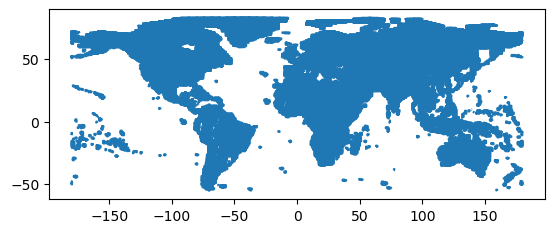

In [14]:
df.exterior.plot()

In [15]:
#df.to_file('hls_metadata.geojson', driver='GeoJSON')

In [16]:
def get_hls_tag_data(url: str) -> dict:
    with rasterio.open(url) as ds:
        t = ds.tags()
    out = {key.lower(): val for key, val in t.items()}
    return out

@backoff.on_exception(backoff.expo,
                      Exception,
                      max_tries=10)
def get_tag_data_from_item(item: dict) -> dict:
    url = item['B04_link']
    return get_hls_tag_data(url)

Sequentially:

In [17]:
tag_data = list(map(get_tag_data_from_item, tqdm(hls_metadata_formatted[:4])))
tag_data

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:13<00:00,  3.42s/it]


[{'accode': 'Lasrc; Lasrc',
  'add_offset': '0.0',
  'area_or_point': 'Area',
  'arop_ave_xshift(meters)': '0, 0',
  'arop_ave_yshift(meters)': '0, 0',
  'arop_ncp': '0, 0',
  'arop_rmse(meters)': '0, 0',
  'arop_s2_refimg': 'NONE',
  'cloud_coverage': '72',
  'hls_processing_time': '2023-05-06T07:14:48Z',
  'horizontal_cs_name': 'UTM, WGS84, UTM ZONE 19; UTM, WGS84, UTM ZONE 18',
  'l1_processing_time': '2023-05-04T21:57:47Z; 2023-05-04T21:56:05Z',
  'landsat_product_id': 'LC09_L1TP_231092_20230504_20230504_02_T1; LC09_L1TP_231093_20230504_20230504_02_T1',
  'landsat_scene_id': 'LC92310922023124LGN00; LC92310932023124LGN00',
  'long_name': 'Red',
  'mean_sun_azimuth_angle': '35.3683882458122',
  'mean_sun_zenith_angle': '70.5678297962547',
  'mean_view_azimuth_angle': '258.522603623321',
  'mean_view_zenith_angle': '3.82482113568492',
  'nbar_solar_zenith': '70.1020025887372',
  'ncols': '3660',
  'nrows': '3660',
  'ovr_resampling_alg': 'NEAREST',
  'processing_level': 'L1TP; L1TP',


Multithread:

In [18]:
n = len(hls_metadata_formatted)
with concurrent.futures.ThreadPoolExecutor(max_workers=100) as executor:
    tag_data = list(tqdm(executor.map(get_tag_data_from_item, hls_metadata_formatted[:]), total=n))

100%|████████████████████████████████████████████████████████████████████████████████████████████| 67480/67480 [24:50<00:00, 45.27it/s]


In [19]:
hls_data_formatted_plus_tags = [{**item, **tag_item} for (item, tag_item) in zip(hls_metadata_formatted, tag_data)]
df_tags = gpd.GeoDataFrame(hls_data_formatted_plus_tags)

In [20]:
df_tags.to_file('hls_metadata_with_tags.geojson', driver='GeoJSON')